In [1]:
import pandas as pd
import librosa
import librosa.display
import IPython.display as ipd     # Проигрывание аудио
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Data

In [2]:
def create_resd_df(resd_path):
    file_path = []
    file_emotion = []

    df_resd_test = pd.read_csv(resd_path + 'test.csv')
    len_test = len(df_resd_test['path'])
    for i in range(len_test):
        file_path.append(resd_path + 'test/' + df_resd_test['path'][i])
        file_emotion.append(df_resd_test['emotion'][i])

    df_resd_train = pd.read_csv(resd_path + 'train.csv')
    len_train = len(df_resd_train['path'])
    for i in range(len_train):
        file_path.append(resd_path + 'train/' + df_resd_train['path'][i])
        file_emotion.append(df_resd_train['emotion'][i])

    df_resd = pd.DataFrame([file_path, file_emotion]).T
    df_resd.columns = ['audio', 'emotions']
    print('Shape RESD dataset:', df_resd.shape)

    return df_resd

In [3]:
resd_path = "D:\\Data Science\\Diploma_SER\\project\\audiofiles\\resd\\"
df_resd = create_resd_df(resd_path)
df_resd.head()

Shape RESD dataset: (1396, 2)


audio    emotions
0  D:\Data Science\Diploma_SER\project\audiofiles...     neutral
1  D:\Data Science\Diploma_SER\project\audiofiles...       anger
2  D:\Data Science\Diploma_SER\project\audiofiles...  enthusiasm
3  D:\Data Science\Diploma_SER\project\audiofiles...       anger
4  D:\Data Science\Diploma_SER\project\audiofiles...        fear

In [4]:
def plot_emotion_distribution(dataframes, dataframe_names):
  for df, name in zip(dataframes, dataframe_names):
    plt.figure(figsize=(6, 4))
    ax = sns.countplot(x='emotions', data=df)
    ax.bar_label(ax.containers[0], fontsize=8)
    plt.title(f'Distribution of Emotions ({name})')
    plt.show()

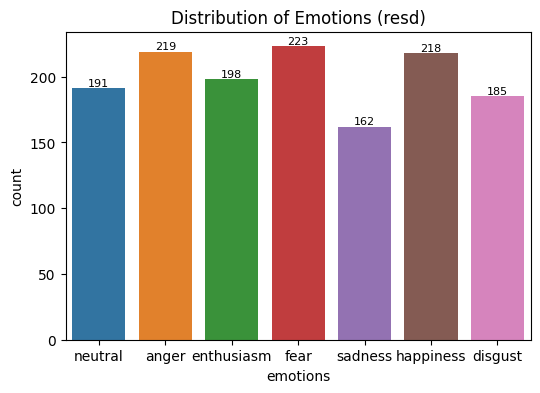

In [5]:
plot_emotion_distribution([df_resd], ['resd'])

In [9]:
emotion_mapping = {'neutral': 0, 'anger': 1, 'enthusiasm': 2, 'fear': 3, 'sadness': 4, 'happiness': 5, 'disgust': 6}
df_resd['labels'] = df_resd['emotions'].map(emotion_mapping)

In [6]:
def plot_waveforn(emotions):
    for emotion in emotions:
        audio_path = df_resd['audio'][df_resd['emotions'] == emotion].iloc[0]

        signal, sr = librosa.load(audio_path)
        plt.figure(figsize=(8, 4))
        librosa.display.waveshow(signal, sr=sr)
        plt.title(f'Waveform of an Audio Sample - {emotion}')
        plt.xlabel("Time (s)")  
        plt.ylabel("Amplitude") 
        plt.show()

        display(ipd.Audio(audio_path, rate=sr))

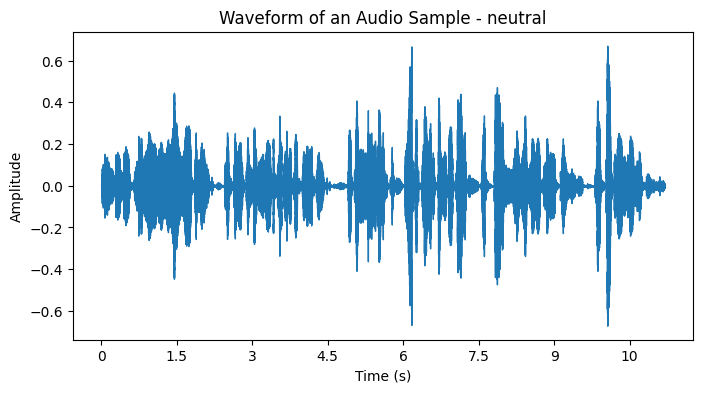

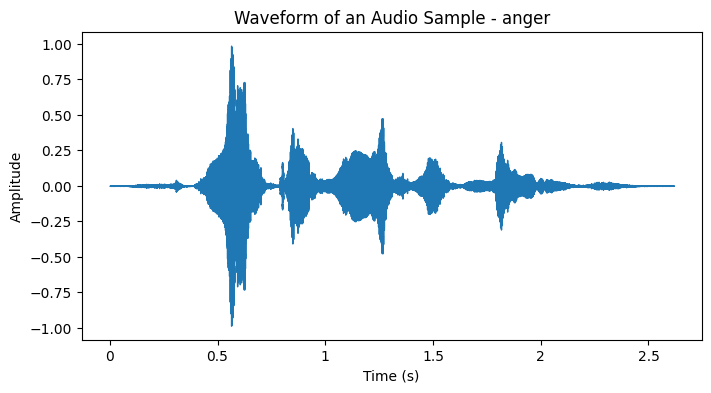

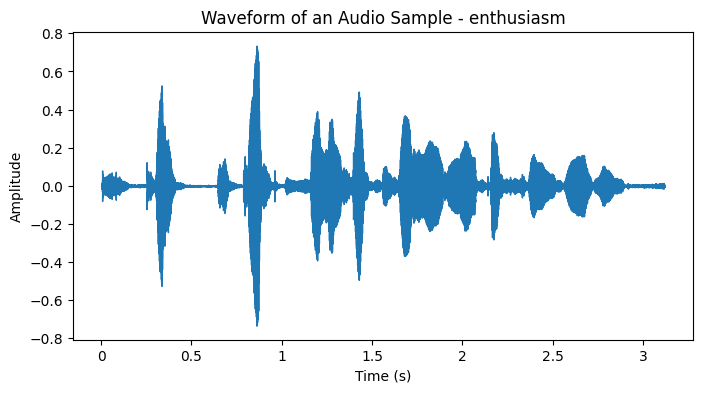

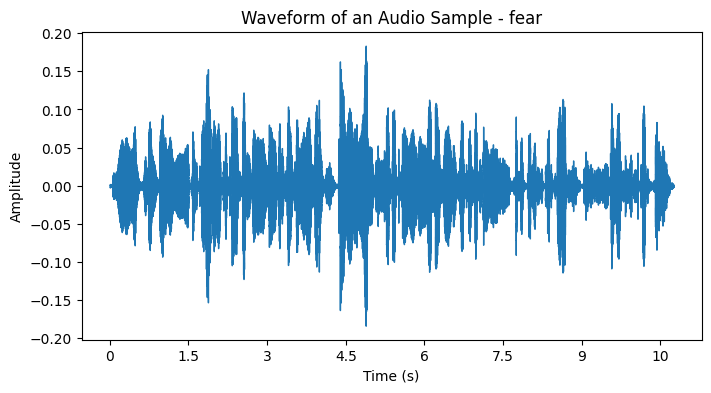

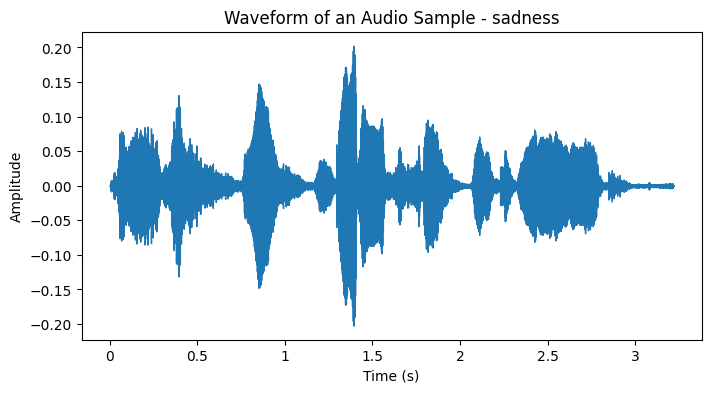

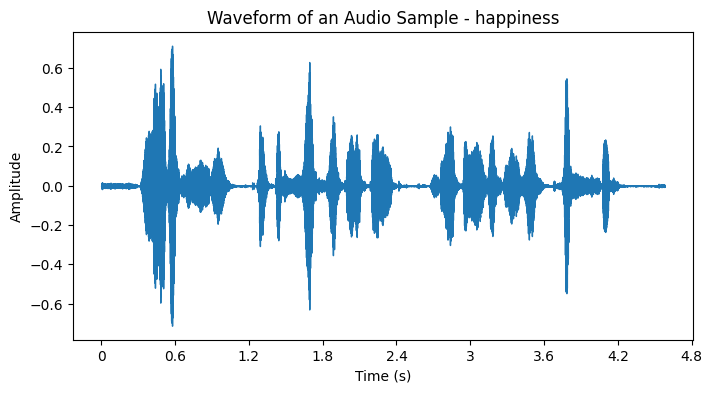

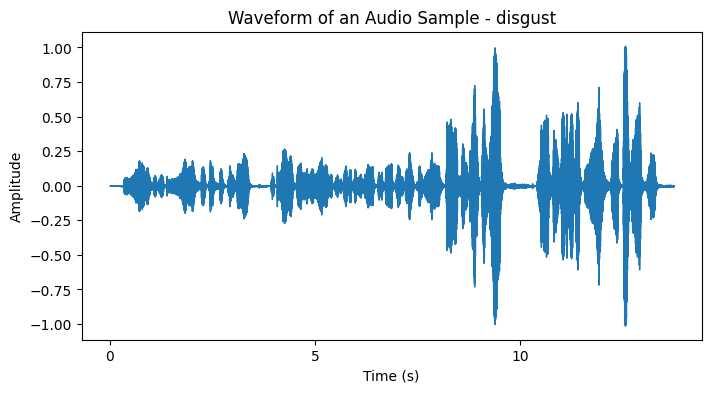

In [7]:
emotions = ['neutral', 'anger', 'enthusiasm', 'fear', 'sadness', 'happiness', 'disgust']
plot_waveforn(emotions)

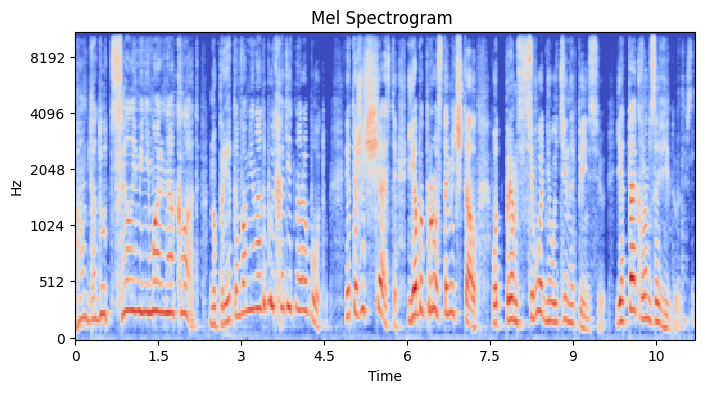

In [11]:
audio_path = df_resd['audio'][df_resd['emotions'] == 'neutral'].iloc[0]
signal, sr = librosa.load(audio_path) 

plt.figure(figsize=(8, 4))
mel = librosa.feature.melspectrogram(y=signal, sr=sr)
log_spectrogram = librosa.power_to_db(mel)
librosa.display.specshow(log_spectrogram, y_axis='mel', sr=sr, x_axis='time');
plt.title('Mel Spectrogram ')
plt.show()

Mean Audio Length: 175870.81446991404
Median Audio Length: 132317.0
Maximum Audio Length: 888143
90th Percentile Audio Length: 400514.5


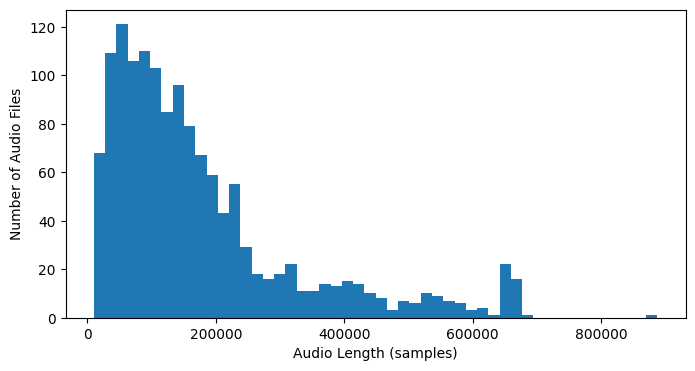

In [12]:
# Audio Length Distribution Analysis
audio_lengths = []
for audio_path in df_resd['audio']:
    audio, sr = librosa.load(audio_path, sr=None) 
    audio_lengths.append(len(audio))

# Audio Length Statistics
print(f"Mean Audio Length: {np.mean(audio_lengths)}")
print(f"Median Audio Length: {np.median(audio_lengths)}")
print(f"Maximum Audio Length: {np.max(audio_lengths)}")
print(f"90th Percentile Audio Length: {np.percentile(audio_lengths, 90)}")

# Audio Length Distribution Histogram
plt.figure(figsize=(8, 4))
plt.hist(audio_lengths, bins=50)
plt.xlabel("Audio Length (samples)")
plt.ylabel("Number of Audio Files")
plt.show() 

Augmentation

In [13]:
# Noise injection
def noise(signal, sr, noise_factor=0.035): 
    noise_amp = noise_factor * np.random.uniform() * np.amax(signal) 
    noised_audio = signal + noise_amp * np.random.normal(size=signal.shape[0]) 
    return noised_audio

# Time stretching
def stretch(signal, sr, stretch_rate=0.8):
    stretched_audio = librosa.effects.time_stretch(signal, rate=stretch_rate) 
    return stretched_audio

# Pitch shifting
def pitch(signal, sr, pitch_factor=0.7):
    pitched_audio = librosa.effects.pitch_shift(signal, sr=sr, n_steps=pitch_factor) 
    return pitched_audio

# Temporal shifting
def shift(signal, sr, shift_range=5):
    shift_amount = int(np.random.uniform(low=-shift_range, high=shift_range) * 1000)
    shifted_audio = np.roll(signal, shift_amount) 
    return shifted_audio

In [14]:
def plot_waveforn_augmentation(augmentation_signals, sr):
    for augmentation_signal, emotion in zip(augmentation_signals, emotions):
        plt.figure(figsize=(8, 4))
        librosa.display.waveshow(augmentation_signal)
        plt.title(f'Waveform of an Augmented Audio')
        plt.xlabel("Time (s)") 
        plt.ylabel("Amplitude") 
        plt.show()

        display(ipd.Audio(augmentation_signal, rate=sr))

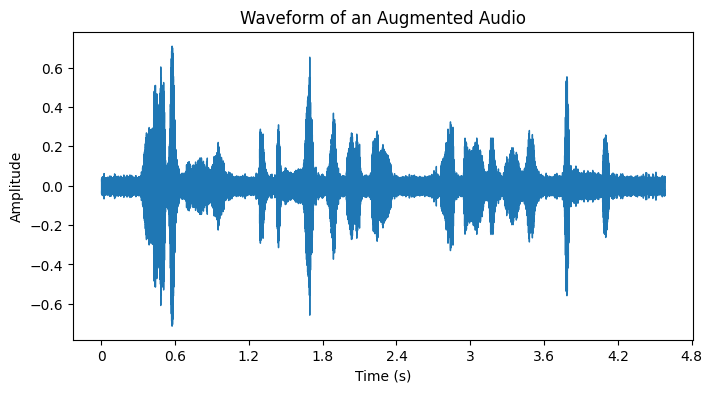

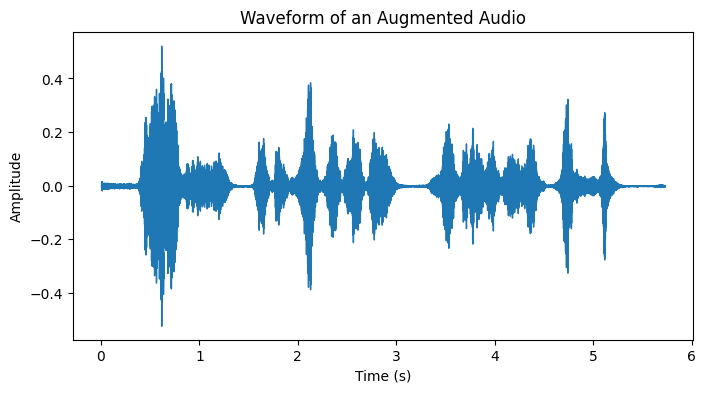

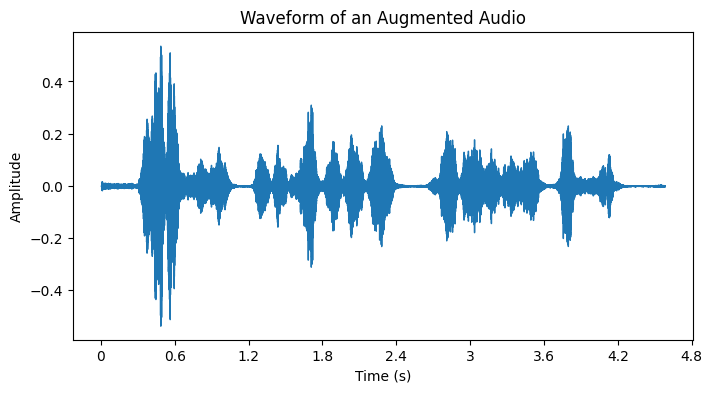

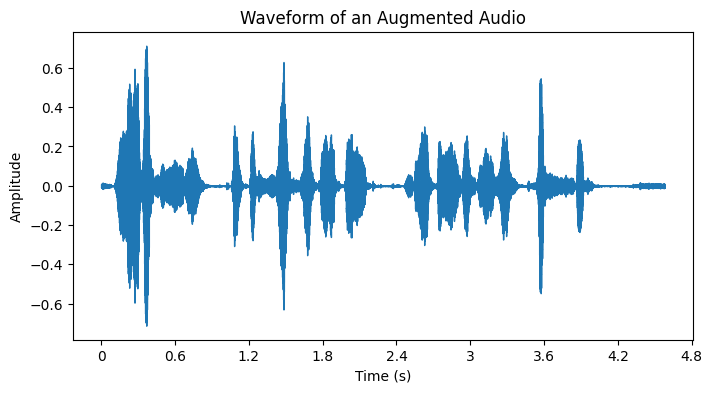

In [15]:
audio_path = df_resd['audio'][df_resd['emotions']=='happiness'].iloc[0]
signal, sr = librosa.load(audio_path)

# Augmentation 
noised_audio = noise(signal, sr)
stretched_audio = stretch(signal, sr)
pitched_audio = pitch(signal, sr)
shifted_audio = shift(signal, sr)  

augmented_audios = [noised_audio, stretched_audio, pitched_audio, shifted_audio]

plot_waveforn_augmentation(augmented_audios, sr)

Data preprocessing

In [17]:
X = df_resd['audio']
y = df_resd['labels']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)

print('Train:', X_train.shape)
print('Test:', X_test.shape)
print('Val:', X_val.shape)

Train: (1004,)
Test: (280,)
Val: (112,)


In [18]:
def extract_features(signal, sr):
    mfccs = np.mean(librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=40).T, axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(y=signal, sr=sr).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=signal, sr=sr).T, axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(y=signal, sr=sr).T, axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=signal, sr=sr).T, axis=0)
    features = np.hstack([mfccs, chroma, mel, contrast, tonnetz]) 
    
    print('Features extracted.')
    return features


def preprocess_audio(audio_path, target_length):
    signal, sr = librosa.load(audio_path)
    
    # Обрезка/дополнение
    if len(signal) > target_length:
        signal = signal[:target_length]
    elif len(signal) < target_length:
        signal = np.pad(signal, (0, target_length - len(signal)), 'constant')
    
    print('Audio processed.')
    return signal, sr  


# Preprocessing
def audio_augmentation(signal, sr):
    augmented_audios = []

    # Noise injection
    noised_audio = noise(signal, sr)
    augmented_audios.append(noised_audio)

    # Time stretching
    stretched_audio = stretch(signal, sr)
    augmented_audios.append(stretched_audio)

    # Pitch shifting
    pitched_audio = pitch(signal, sr)
    augmented_audios.append(pitched_audio)

    # Temporal shifting
    shifted_audio = shift(signal, sr)
    augmented_audios.append(shifted_audio)

    print('Audio augmented.')
    return augmented_audios


def preprocess_data(X, y, target_length, augment=False):
    """Предобрабатывает данные."""
    features = []
    labels = []
    count = 0
    for audio_path, emotion in zip(X, y):
        # Feature extraction
        signal, sr = preprocess_audio(audio_path, target_length) 
        audio_features = extract_features(signal, sr)  
        features.append(audio_features)
        labels.append(emotion)

        # Data augmentation (if augment=True)
        if augment:
            augmented_audios = audio_augmentation(signal, sr)
            for augmented_audio in augmented_audios:  
                augmented_features = extract_features(augmented_audio, sr=sr)
                features.append(augmented_features)
                labels.append(emotion)

        count += 1
        print(f'Audiofile {count} processed.')
    
    # Feature scaling
    scaler = StandardScaler()
    features = scaler.fit_transform(np.array(features))
        
    labels = np.array(labels)  

    return features, labels

In [ ]:
target_length = int(np.percentile(audio_lengths, 90)) # Целевая длина в сэмплах

X_train_processed, y_train_processed = preprocess_data(X_train, y_train, target_length, augment=True)
X_val_processed, y_val_processed = preprocess_data(X_val, y_val, target_length, augment=False)
X_test_processed, y_test_processed = preprocess_data(X_test, y_test, target_length, augment=False)

In [21]:
def evaluate_classification_performance(true_labels, predicted_labels, train):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    cm = confusion_matrix(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-score: {f1}")

    # Visualization - Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=train['emotions'].unique(), 
                yticklabels=train['emotions'].unique())
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


def plot_training_history(history):
  plt.figure(figsize=(15, 5)) 
  
  plt.subplot(1, 2, 1)
  plt.plot(history.history['accuracy'], label='Train Accuracy')
  plt.plot(history.history['val_accuracy'], label='Validation Accuracy') 
  plt.title('Accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss') 
  plt.title('Loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend()

  plt.show()

NN Conv1D

In [ ]:
input_layer = Input(shape=(X_train_processed.shape[1], 1)) 
x = Conv1D(256, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(input_layer)
x = BatchNormalization()(x) 
x = MaxPooling1D(2)(x)
x = Conv1D(128, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
x = MaxPooling1D(2)(x)
x = Conv1D(256, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
x = MaxPooling1D(2)(x)  
x = Dropout(0.5)(x) 
x = Conv1D(512, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.001))(x) 
x = MaxPooling1D(2)(x)
x = Dropout(0.2)(x)
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = Dropout(0.1)(x) 
output_layer = Dense(7, activation='softmax')(x)  

model = Model(inputs=input_layer, outputs=output_layer)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy']) 

early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('emotion_audio_model.keras', monitor='val_accuracy', save_best_only=True)

history = model.fit(
    X_train_processed.reshape(X_train_processed.shape[0], X_train_processed.shape[1], 1), 
    y_train_processed,
    batch_size=32,
    epochs=200,
    validation_data=(X_val_processed, y_val_processed),
    shuffle=True,
    use_multiprocessing=True,
    callbacks=[early_stopping, model_checkpoint]
)

9/9 [==============================] - 0s 15ms/step
Accuracy: 0.7428571428571429
Precision: 0.762371892089118
Recall: 0.7428571428571429
F1-score: 0.7412187993193904


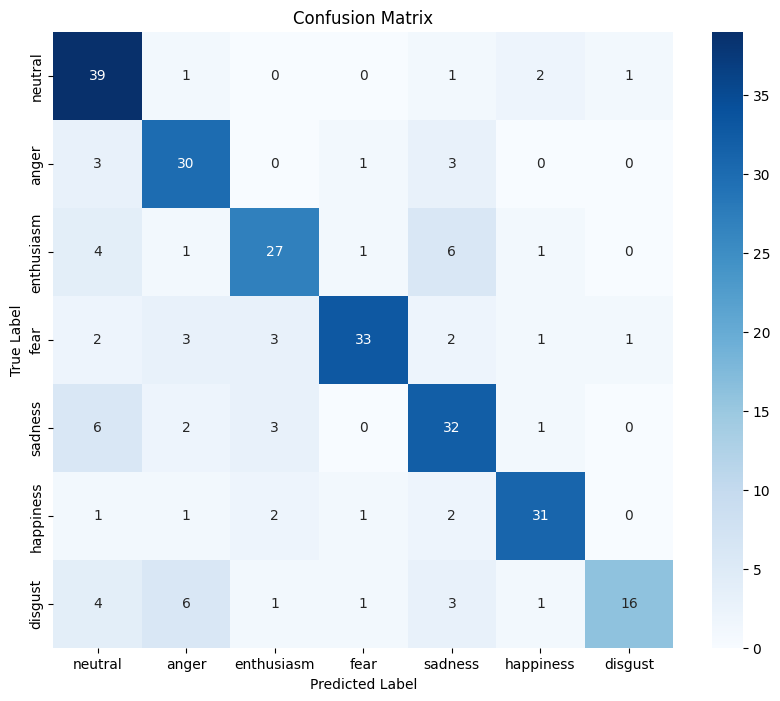

In [30]:
# Model Validation
y_pred = model.predict(X_test_processed.reshape(X_test_processed.shape[0], X_test_processed.shape[1], 1))
y_pred_classes = np.argmax(y_pred, axis=1)

evaluate_classification_performance(y_test_processed, y_pred_classes, df_resd)

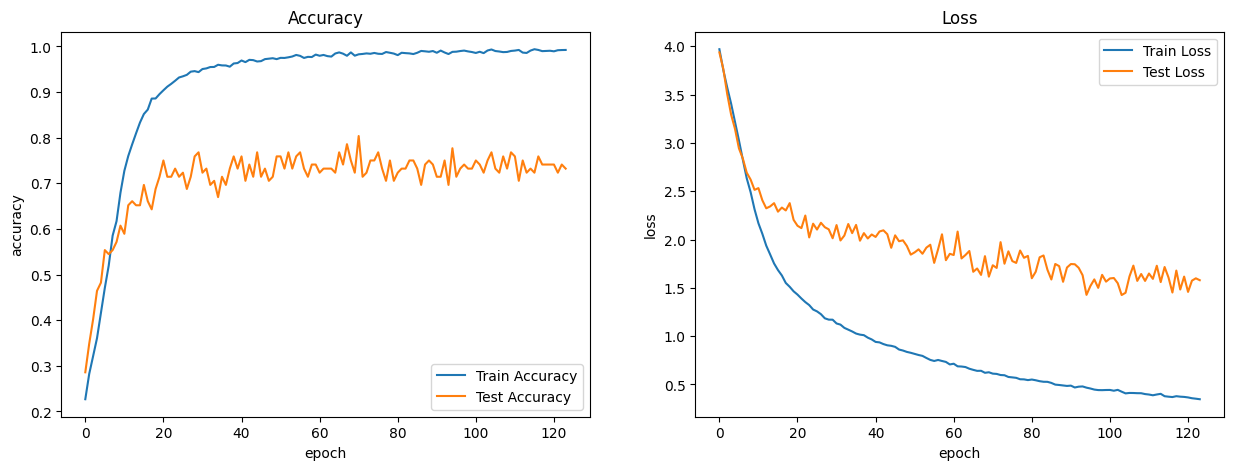

In [32]:
plot_training_history(history)

NN Conv2d

In [119]:
# Обрезка аудио в сэмплах
def trim_audio_samples(audio_path, target_samples):
    signal, sr = librosa.load(audio_path, sr=22050)
    trimmed_signal = librosa.util.fix_length(signal, size=target_samples)
    return trimmed_signal

# Загрузка данных и обрезка аудио
audio_files = df_resd['audio'].values  
y = df_resd['emotions'].values  

target_samples = int(np.percentile(audio_lengths, 90))   # Целевая длина аудио в сэмплах
trimmed_audio_files = [trim_audio_samples(file, target_samples) for file in audio_files]

# Преобразование меток классов
le = LabelEncoder()
y = le.fit_transform(y)

# Разделение данных на обучающую, тестовую и валидационную выборки
indices = np.arange(len(audio_files))
train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=42, stratify=y)
train_indices, val_indices = train_test_split(train_indices, test_size=0.1, random_state=42)

# Создание спектрограмм
def create_spectrograms(audio_files, sr, indices):
    spectrograms = []
    for i in indices:
        signal = audio_files[i]  
        mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sr)
        spectrograms.append(mel_spectrogram)
    return np.array(spectrograms)

sr = 22050 
X_train_spectrograms = create_spectrograms(trimmed_audio_files, sr, train_indices)
X_val_spectrograms = create_spectrograms(trimmed_audio_files, sr, val_indices)
X_test_spectrograms = create_spectrograms(trimmed_audio_files, sr, test_indices)

# Преобразование в 3-мерный тензор
X_train_spectrograms = X_train_spectrograms[..., np.newaxis]
X_val_spectrograms = X_val_spectrograms[..., np.newaxis]
X_test_spectrograms = X_test_spectrograms[..., np.newaxis]


# Model Conv2D
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=X_train_spectrograms.shape[1:]),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3), 
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(7, activation='softmax')  
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3) 

history = model.fit(
    X_train_spectrograms, y[train_indices], 
    epochs=10,
    batch_size=32,
    validation_data=(X_val_spectrograms, y[val_indices]), 
    callbacks=[early_stopping]
)

9/9 [==============================] - 2s 234ms/step
Accuracy: 0.29285714285714287
Precision: 0.2791840698983556
Recall: 0.29285714285714287
F1-score: 0.27918245477098524


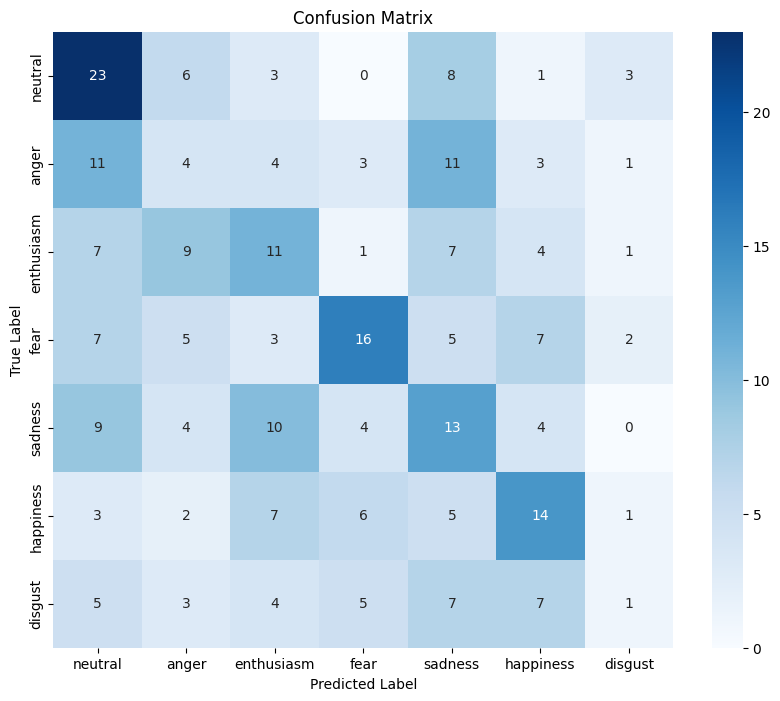

In [131]:
# Model Validation
y_pred = model.predict(X_test_spectrograms)
y_pred_classes = np.argmax(y_pred, axis=1) 

evaluate_classification_performance(y[test_indices], y_pred_classes, df_resd)

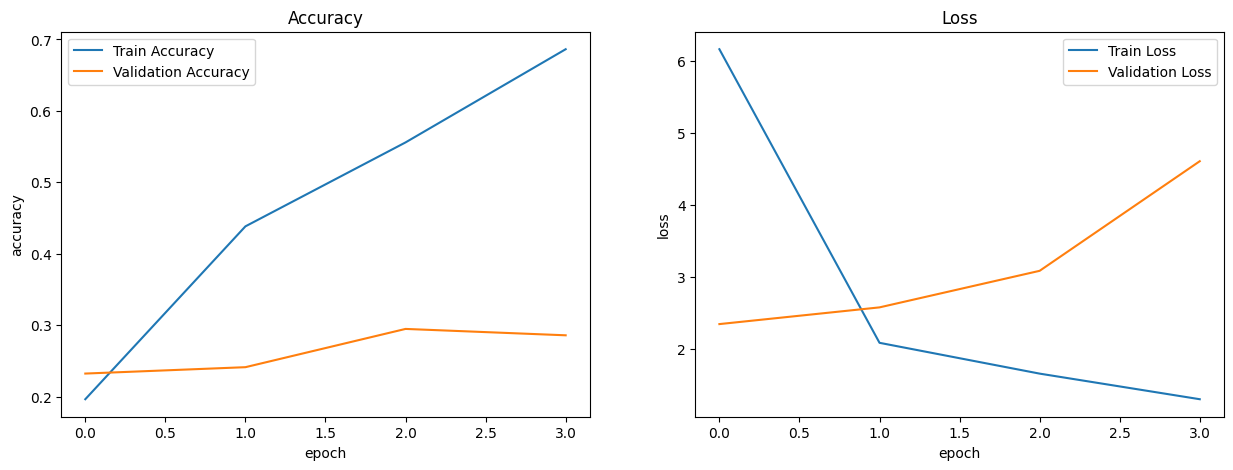

In [132]:
plot_training_history(history)